<a href="https://colab.research.google.com/github/ifty54/Projects/blob/main/Deep_Learning_with_PyTorch_Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1 : Set up colab gpu runtime environment

In [52]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-_rvqm7hw
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-_rvqm7hw
  Resolved https://github.com/albumentations-team/albumentations to commit e3b47b3a127f92541cfeb16abbb44a6f8bf79cc8
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [53]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


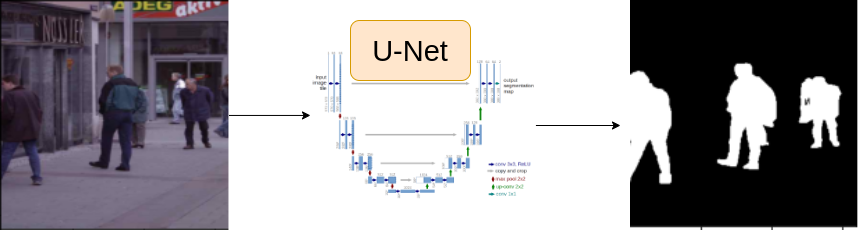

# Some Common Imports

In [54]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [55]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Step : 2 Setup Configurations

In [56]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

device = 'cuda'

EPOCHS = 20
LR = 0.003
IMG_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [57]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [58]:
row = df.iloc[2]

mask_path = row.masks
image_path = row.images

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #BGR2RGB conversion required as OpenCV reads BGR only

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/255.0

# Resize the image and mask to the same dimensions
images = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
masks = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))


# Visualization

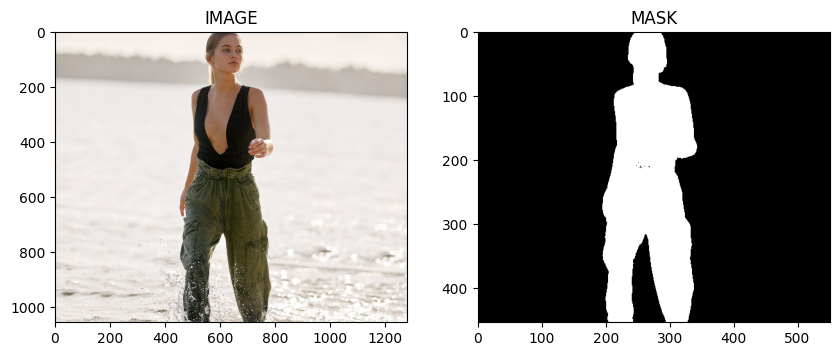

In [59]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('MASK')
ax2.imshow(mask,cmap = 'gray')

In [60]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

# Step 3 : Augmentation Functions





albumentation documentation : https://albumentations.ai/docs/

In [61]:
import albumentations as A

def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5)
  ], is_check_shapes = 0)
def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE)
  ], is_check_shapes = 0)

# Step 4 : Create Custom Dataset

In [62]:
from torch.utils.data import Dataset

In [63]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #h,w exist
    mask = np.expand_dims(mask, axis = -1) #now its h, w, c

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

      #h,w,c -> c,w,h (channel, weight, height)

      image = np.transpose(image, (2,0,1)).astype(np.float32)
      mask = np.transpose(mask, (2,0,1)).astype(np.float32)

      image = torch.Tensor(image)/255.0
      mask = torch.round(torch.Tensor(mask)/255.0)

      return image, mask


In [64]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [65]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


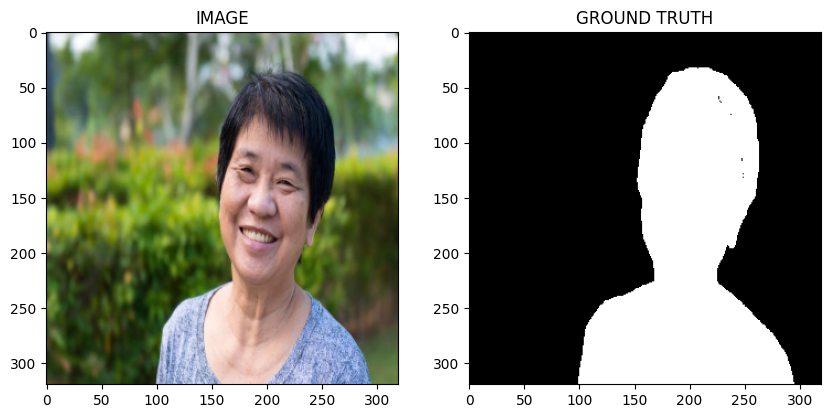

In [66]:
idx = 3
image, mask = trainset[idx]

helper.show_image(image, mask)

# Step 5 : Load dataset into batches

In [67]:
from torch.utils.data import DataLoader

trainloader = DataLoader(trainset, batch_size= BATCH_SIZE, shuffle= True)
validloader = DataLoader(validset, batch_size= BATCH_SIZE)

print(f"Number of trainloader is: {len(trainloader)}")
print(f"Number of validloader is: {len(validloader)}")

Number of trainloader is: 15
Number of validloader is: 4


In [68]:
print(f"One batch image shape: {image.shape}")
print(f"One batch mask shape: {mask.shape}")

One batch image shape: torch.Size([3, 320, 320])
One batch mask shape: torch.Size([1, 320, 320])


# Step 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [69]:
!pip install segmentation-models-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [70]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [71]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )
  def forward(self, images, masks= None):
    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1+loss2

    return logits


In [72]:
model = SegmentationModel()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

# Step 7 : Create Train and Validation Function

In [73]:
def train_fn(data_loader, model, optimizer):
  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):

    images = images.to(device)
    masks = masks.to(device)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)

In [74]:
def eval_fn(data_loader, model):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():

    for images, masks in tqdm(data_loader):

      images = images.to(device)
      masks = masks.to(device)
      logits, loss = model(images, masks)
      total_loss += loss.item()

  return total_loss/len(data_loader)

# Step 8 : Train Model

In [75]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [76]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'my-model.pt')
    print("Saved the model")
    best_valid_loss = valid_loss

  print(f"Epochs: {i+1} | Train Loss: {train_loss} | Validation Loss: {valid_loss}")


100%|██████████| 4/4 [00:17<00:00,  4.43s/it]


Saved the model
Epochs: 1 | Train Loss: 0.766643879810969 | Validation Loss: 0.8881968110799789


100%|██████████| 4/4 [00:17<00:00,  4.39s/it]


Saved the model
Epochs: 2 | Train Loss: 0.3310496817032496 | Validation Loss: 0.4943539798259735


100%|██████████| 4/4 [00:18<00:00,  4.50s/it]


Saved the model
Epochs: 3 | Train Loss: 0.2710615426301956 | Validation Loss: 0.4034547507762909


100%|██████████| 4/4 [00:17<00:00,  4.39s/it]


Saved the model
Epochs: 4 | Train Loss: 0.2543334782123566 | Validation Loss: 0.24583053588867188


100%|██████████| 4/4 [00:17<00:00,  4.38s/it]


Epochs: 5 | Train Loss: 0.21706791420777638 | Validation Loss: 0.27400118112564087


100%|██████████| 4/4 [00:18<00:00,  4.61s/it]


Saved the model
Epochs: 6 | Train Loss: 0.23071069419384002 | Validation Loss: 0.20937079936265945


100%|██████████| 4/4 [00:18<00:00,  4.65s/it]


Epochs: 7 | Train Loss: 0.19069121281305948 | Validation Loss: 0.21375462412834167


100%|██████████| 4/4 [00:17<00:00,  4.42s/it]


Epochs: 8 | Train Loss: 0.19799786508083345 | Validation Loss: 0.21641459688544273


100%|██████████| 4/4 [00:17<00:00,  4.40s/it]


Epochs: 9 | Train Loss: 0.14911646097898484 | Validation Loss: 0.2288157418370247


100%|██████████| 4/4 [00:18<00:00,  4.71s/it]


Saved the model
Epochs: 10 | Train Loss: 0.16895832121372223 | Validation Loss: 0.1824924796819687


100%|██████████| 4/4 [00:18<00:00,  4.52s/it]


Epochs: 11 | Train Loss: 0.1527242988348007 | Validation Loss: 0.19443880021572113


100%|██████████| 4/4 [00:17<00:00,  4.42s/it]


Epochs: 12 | Train Loss: 0.137994284927845 | Validation Loss: 0.24885499477386475


100%|██████████| 4/4 [00:17<00:00,  4.38s/it]


Epochs: 13 | Train Loss: 0.1665162593126297 | Validation Loss: 0.30983829870820045


100%|██████████| 4/4 [00:18<00:00,  4.72s/it]


Epochs: 14 | Train Loss: 0.18355394999186198 | Validation Loss: 0.26534969359636307


100%|██████████| 4/4 [00:17<00:00,  4.45s/it]


Saved the model
Epochs: 15 | Train Loss: 0.14737809002399443 | Validation Loss: 0.18033530935645103


100%|██████████| 4/4 [00:17<00:00,  4.31s/it]


Epochs: 16 | Train Loss: 0.11872905095418294 | Validation Loss: 0.2594441771507263


100%|██████████| 4/4 [00:17<00:00,  4.43s/it]


Epochs: 17 | Train Loss: 0.21072350740432738 | Validation Loss: 0.25742646493017673


100%|██████████| 4/4 [00:17<00:00,  4.38s/it]


Epochs: 18 | Train Loss: 0.17209708740313848 | Validation Loss: 0.22639427334070206


100%|██████████| 4/4 [00:17<00:00,  4.35s/it]


Epochs: 19 | Train Loss: 0.14287852346897126 | Validation Loss: 0.2239205799996853


100%|██████████| 4/4 [00:17<00:00,  4.29s/it]

Epochs: 20 | Train Loss: 0.14937426994244257 | Validation Loss: 0.21659821271896362


# Step 9 : Inference

In [77]:
idx = 2

model.load_state_dict(torch.load('/content/my-model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(device).unsqueeze(0)) # c,h,w -> 1,c,h,w

pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

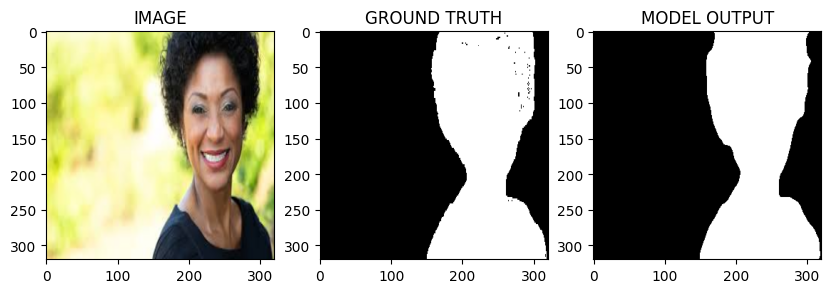

In [78]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))